In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [0]:
# Install autoscroll plugin for ipynb

# !git clone https://github.com/ipython-contrib/IPython-notebook-extensions.git
# !python ./IPython-notebook-extensions/setup.py install

In [0]:
# !kill -9 -1

In [0]:
import numpy as np

import torch
import os
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.image as mpimg
from torch.utils import data
from torch.optim import Adam, SGD
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [0]:
if "data" not in os.listdir('.'):
  !unzip data.zip

In [0]:
# !rm -r data
# !rm data.zip
# !rm -r __MACOSX

In [0]:
def cnn_out_size(input_dim, padding, kernel_size, stride):
    return ((input_dim + 2 * padding - kernel_size) // stride) + 1

In [0]:
USE_CUDA = True
input_dim = 36
kernel_size = 9
stride = 2
capsule_input = cnn_out_size(cnn_out_size(input_dim, 0, kernel_size, 1), 0, kernel_size, stride)
num_classes=25
capsule_dimension = 32
learning_rate = 0.005
momentum = 0.95

In [0]:
class DataLoad(data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, src, list_IDs, labels):
        'Initialization'
        self.src = src
        self.list_IDs = list_IDs
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        img = mpimg.imread(self.src + ID)
#         plt.imshow(img)
#         plt.show()

#         X = torch.Tensor(img).view(3, img_dimension, img_dimension)
        X = torch.Tensor(reshape_image_tensor_channels_first(img))
        y = self.labels[index]

        return X, y

In [0]:
class LFW:
    def __init__(self, batch_size):
        src = './data/lfw/'
        test_src = './data/cplfw/'

        # Training images - LFW
        images, targets = self.load_data(src)
        dataset_size = len(images)
#         validation_split = 0.1
#         split = int(np.floor(validation_split * dataset_size))

        indices = list(range(dataset_size))
#         train_indices, test_indices = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(indices)
#         train_sampler = SubsetRandomSampler(train_indices)
#         test_sampler = SubsetRandomSampler(test_indices)

        dataset = DataLoad(src, images, targets)
        
        # Test images - CPLFW
        images, targets = self.load_data(test_src)
        testset_size = len(images)
        indices = list(range(testset_size))
        test_sampler = SubsetRandomSampler(indices)
        
        testset = DataLoad(test_src, images, targets)

        # Dataloader parameters
        params = {
            'batch_size': batch_size,
            'shuffle': False,
            'num_workers': 6,
            'drop_last': True
        }

        self.train_loader = torch.utils.data.DataLoader(dataset, sampler=train_sampler, **params)
        self.test_loader = torch.utils.data.DataLoader(testset, sampler=test_sampler, **params)


    def load_data(self, src):

        images = list()
        targets = list()
        classes = os.listdir(src)

        self.n_classes = len(classes)

        # Mac-specific
        if '.DS_Store' in classes:
            classes.remove('.DS_Store')

        for label in classes:
            path = src + label + '/'
            image_paths = os.listdir(path)
            for image in image_paths:
                images.append(label + '/' + image)
                targets.append(classes.index(label))

        return images, targets

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=3, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=1
                             )

    def forward(self, x):
        return F.relu(self.conv(x))

In [0]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=12, in_channels=256, out_channels=32, kernel_size=9):
        super(PrimaryCaps, self).__init__()
        
        self.out_channels = out_channels
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), self.out_channels * capsule_input * capsule_input, -1)
        return self.squash(u)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

In [0]:
class FaceCaps(nn.Module):
    def __init__(self, num_capsules=num_classes, num_routes=32 * capsule_input * capsule_input, in_channels=12, out_channels=capsule_dimension):
        super(FaceCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)
        
        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)

            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm * input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(capsule_dimension * num_classes, 1024 * 3),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024 * 3, 2048 * 3),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(2048 * 3, input_dim*input_dim * 3)
        )
        
    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes)
        
        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(num_classes))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=max_length_indices.squeeze(1).data)
        
        reconstructions = self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), -1))
        reconstructions = reconstructions.view(-1, 3, input_dim, input_dim)
        
        return reconstructions, masked

In [0]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.face_capsules = FaceCaps()
        self.decoder = Decoder()

        self.mse_loss = nn.MSELoss()

    def forward(self, data):
        output = self.face_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked

    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)

    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x ** 2).sum(dim=2, keepdim=True))

        ## Change to add squa
        left = (F.relu(0.9 - v_c)**2).view(batch_size, -1)
        right = (F.relu(v_c - 0.1)**2).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss

    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.00005

In [0]:
def reshape_image_tensor(img):
  reshaped_img = np.zeros((input_dim,input_dim,3))
  for channel in range(3):
    for i in range(input_dim):
      for j in range(input_dim):
        if not math.isnan(img[channel, i, j]):
          reshaped_img[i, j, channel] = int(img[channel, i, j])
  return reshaped_img.astype(int)

def reshape_image_tensor_channels_first(img):
  reshaped_img = np.zeros((3,input_dim,input_dim))
  for i in range(input_dim):
    for j in range(input_dim):
      for channel in range(3):
        reshaped_img[channel, i, j] = int(img[i, j, channel])
  return reshaped_img.astype(int)

In [0]:
def reconstruction_loss(data, reconstructions):
  loss = nn.MSELoss(reconstructions, data)
  return loss

In [0]:
def normalize_images(img):
  min_i = np.min(img)
  max_i = np.max(img)
  img = ((img - min_i) / (max_i.item() - min_i.item()))
  return img

In [19]:
try:
  capsule_net
except NameError:
  capsule_net = CapsNet()
  print("well, it WASN'T defined after all!")
else:
  del capsule_net
  capsule_net = CapsNet()
  print("CapsNet is already defined.")

well, it WASN'T defined after all!


In [20]:
batch_size = 28
lfw = LFW(batch_size)

if USE_CUDA:
    capsule_net = capsule_net.cuda()
optimizer = Adam(capsule_net.parameters())
# optimizer = SGD(capsule_net.parameters(), lr = learning_rate, momentum=momentum)

n_epochs = 50

train_losses = list()
train_accuracies = list()

test_losses = list()
test_accuracies = list()

for epoch in range(n_epochs):
    print("################ EPOCH %d ################"%(epoch))
    capsule_net.train()
    train_loss = 0
    for batch_id, (data, target) in enumerate(lfw.train_loader):
        img = reshape_image_tensor(data[0,:,:,:].data.cpu().numpy())

        target = torch.sparse.torch.eye(lfw.n_classes).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
#         try:
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()
#         Trick to clear gpu memory
#         except RuntimeError as e:
#           if 'out of memory' in str(e):
#             print('| WARNING: ran out of memory, retrying batch')
#             for p in capsule_net.parameters():
#                 if p.grad is not None:
#                     del p.grad  # free some memory
#             torch.cuda.empty_cache()

        train_loss += loss.item()
        torch.cuda.empty_cache()

        if batch_id % 100:
#             reconstruction = normalize_images(reshape_image_tensor(reconstructions[0,:,:,:].data.cpu().numpy()))
#             plt.imshow(reconstruction)
#             plt.show()
#             print("Reconstruction loss: ",reconstruction_loss(data[0,:,:,:].data.cpu().numpy(),
#                                                              reconstructions[0,:,:,:].data.cpu().numpy()))
            train_accuracies.append(sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                                   np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size))
            print("Train accuracy:", train_accuracies[-1])

    train_losses.append(train_loss / len(lfw.train_loader))
    print ("Train loss", train_losses[-1])
    
    capsule_net.eval()
    test_loss = 0
    for batch_id, (data, target) in enumerate(lfw.test_loader):
        target = torch.sparse.torch.eye(lfw.n_classes).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)
        
        if USE_CUDA:
          data, target = data.cuda(), target.cuda()
          
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        
        test_loss += loss.item()
        
        if batch_id % 100:
#             reconstruction = normalize_images(reshape_image_tensor(reconstructions[0,:,:,:].data.cpu().numpy()))
#             plt.imshow(reconstruction)
#             plt.show()
            test_accuracies.append(sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                                   np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size))
            print("Test accuracy:", test_accuracies[-1])

    test_losses.append(test_loss / len(lfw.test_loader))
    print ("Test loss", test_losses[-1])
    print ("------------------------")

################ EPOCH 0 ################


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train accuracy: 0.17857142857142858
Train accuracy: 0.21428571428571427
Train accuracy: 0.03571428571428571
Train accuracy: 0.2857142857142857
Train accuracy: 0.21428571428571427
Train accuracy: 0.21428571428571427
Train accuracy: 0.17857142857142858
Train accuracy: 0.10714285714285714
Train accuracy: 0.17857142857142858
Train accuracy: 0.2857142857142857
Train accuracy: 0.10714285714285714
Train accuracy: 0.10714285714285714
Train accuracy: 0.21428571428571427
Train accuracy: 0.17857142857142858
Train accuracy: 0.25
Train accuracy: 0.32142857142857145
Train accuracy: 0.35714285714285715
Train accuracy: 0.17857142857142858
Train accuracy: 0.10714285714285714
Train accuracy: 0.17857142857142858
Train accuracy: 0.17857142857142858
Train accuracy: 0.2857142857142857
Train accuracy: 0.35714285714285715
Train accuracy: 0.32142857142857145
Train accuracy: 0.10714285714285714
Train accuracy: 0.35714285714285715
Train accuracy: 0.35714285714285715
Train accuracy: 0.17857142857142858
Train accu

KeyboardInterrupt: ignored

# Loss and accuracy plots


In [0]:
def plot_loss(losses, epochs):
  plt.plot(range(epochs), losses)
  plt.title("Losses")
  plt.show()
  
def plot_accuracy(accuracies, epochs):
  plt.plot(range(epochs), accuracies)
  plt.title("Accuracies")
  plt.show()

In [0]:
def plot_curves(train_losses, test_losses=None, title=None, xl='Epoch', yl='Loss'):
    plt.style.use('seaborn')
    plt.plot(train_losses, label='Training accuracy')
    if test_losses: plt.plot(test_losses, label='Validation accuracy')
    plt.xlabel(xl)
    plt.ylabel(yl)
    if title: plt.title(title)
    plt.legend(frameon=False)
    plt.show()

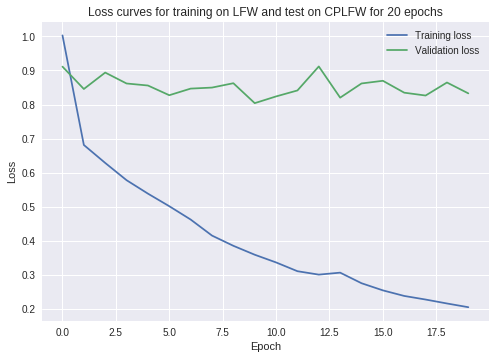

In [75]:
plot_curves(train_losses, test_losses, "Loss curves for training on LFW and test on CPLFW for 20 epochs")

In [0]:
train_acc = []
step = len(train_accuracies) / len(lfw.train_loader)
for i in range(20):
  acc = sum(train_accuracies[i*73:min(i*73+73, len(train_accuracies))]) / len(train_accuracies[i*73:min(i*73+73, len(train_accuracies))])
  train_acc.append(acc)

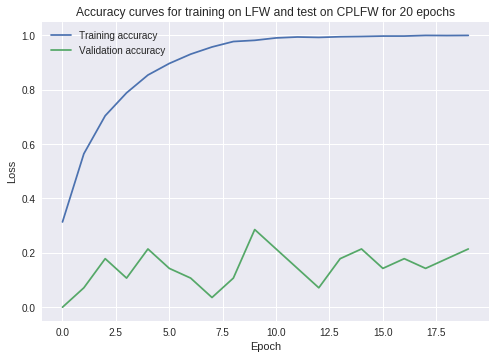

In [88]:
plot_curves(train_acc, test_accuracies, "Accuracy curves for training on LFW and test on CPLFW for 20 epochs")

# Image visualization

In [0]:
import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    "Plot the six LFW images separately."
    fig = plt.figure()
    for j in range(1, images.shape[0]+1):
#         ax = fig.add_subplot(1, images.shape[0], j)
        plt.imshow(images[j-1])#, cmap = matplotlib.cm.binary)
        plt.show()
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
#     plt.show()

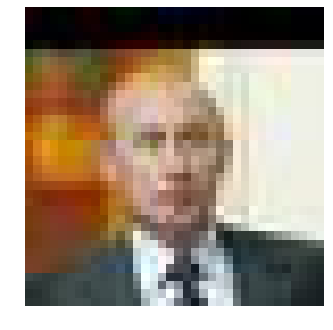

In [43]:
plt.imshow(reshape_image_tensor(data[15,:,:,:].data.cpu().numpy()))
plt.axis('off')
plt.show()

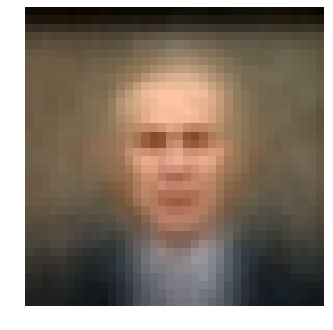

In [44]:
reconstruction = normalize_images(reshape_image_tensor(reconstructions[15,:,:,:].data.cpu().numpy()))
plt.imshow(reconstruction)
plt.axis('off')
plt.show()

# Image reconstruction analysis

In [0]:
# src = 'data/lfw/Andre_Agassi/Andre_Agassi_0001.jpg'
# img = mpimg.imread(src)
# plt.imshow(img)
# plt.show()

In [0]:
# s = 'data/lfw/Andre_Agassi/Andre_Agassi_0001.jpg'
# im = mpimg.imread(s)
# X = torch.Tensor(reshape_image_tensor_channels_first(im))
# img = reshape_image_tensor(X).astype(int)
# print(im)
# print('-----')
# print(img.astype(int))
# plt.imshow(img)
# plt.show()

# Garbage collect gpu memory

In [0]:
# import torch
# import gc
# for obj in gc.get_objects():
#     if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#       print(type(obj), obj.size())